# Transfer ResNet18 model

## 1. 공식 문서의 resnet18 설명을 참고하여 ResNet18 모델을 로드 합니다.


* weights 는 ResNet18_Weights.IMAGENET1K_V2 사용합니다.
* model 을 로드한 후 구조를 콘솔에 출력해 봅니다.

https://pytorch.org/vision/main/models/generated/torchvision.models.resnet18.html#resnet18

In [1]:
from torchvision.models import resnet18, ResNet18_Weights

In [2]:
weights = ResNet18_Weights.IMAGENET1K_V1
model = resnet18(weights=weights)
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

## 2. 로드한 모델의 파라미터가 학습 중 update 되지 않도록 조치합니다.

In [3]:
for p in model.parameters():
  p.requires_grad = False

## 3. Pytorch 의 ResNet18 모델은 IMAGENET1K 를 이용하여 사전 훈련됐습니다(출력이 1000개).

* 모델의 마지막 레이이인 fully connected 를 새로운 Linear 레이어로 변경합니다. 이때, Linear 레이어의 출력은 FashionMNIST 데이터셋의 label 개수를 고려하여 10 입니다.


* 마지막으로 torch.rand 를 이용하여 (32, 3, 224, 224) 크기의 데이터를 생성하여 모델에 입력으로 제공하고 출력의 shape 이 (32, 10) 임을 확인합니다.

In [4]:
import torch.nn as nn
import torch

model.fc = nn.Linear(512, 10)

In [5]:
input = torch.rand(32, 3, 224, 224)
x = model(input)
x.shape

torch.Size([32, 10])

## 3.1 모델의 규모가 크기 때문에 GPU 를 이용할 수 있는 경우 이를 사용하여 모델을 학습합니다. 먼저, 로드한 모델을 GPU 로 이동합니다.

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [7]:
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

## 4. Pytorch 의 ResNet18 모델은 IMAGENET1K 를 이용하여 사전 훈련됐습니다. 따라서, (224, 224) 크기의 컬러 이미지를 입력으로 받습니다.

* FashionMNIST 는 (1, 28, 28) 크기로 모델을 입력으로 사용할 수 없기 때문에 변환(transform) 이 필요합니다. 제공되는 transform 을 이용하여 FasionMNIST 데이터셋을 resnet18 의 입력으로 사용할 수 있도록 코드를 작성하세요.

https://pytorch.org/vision/main/models/generated/torchvision.models.resnet18.html#torchvision.models.ResNet18_Weights


In [8]:
from torchvision import transforms
from torchvision.transforms import InterpolationMode

In [9]:
from torchvision.datasets import FashionMNIST
from torch.utils.data import DataLoader

crop_size = weights.transforms.keywords['crop_size']
resize_size = 224

transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((resize_size, resize_size), interpolation=InterpolationMode.BILINEAR),
    transforms.CenterCrop((crop_size, crop_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

dataset_train = FashionMNIST('data', download=True, transform=transform)
dataset_test = FashionMNIST('data', download=True, transform=transform)

loader_train = DataLoader(dataset_train, batch_size=1024, shuffle=True)
loader_test = DataLoader(dataset_test, batch_size=1024, shuffle=True)

In [10]:
for X, y in loader_train:
  print(X.shape, y.shape, X.device, y.device)
  break

torch.Size([1024, 3, 224, 224]) torch.Size([1024]) cpu cpu


## 5. 손실함수 (torch.nn.CrossEntropyLoss) 와 옵티마이저(torch.optim.Adam) 를 생성합니다.

In [11]:
import torch.optim as optim

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

## 6. train loop 를 구현하여 모델을 학습시켜 봅니다. 또한, loss_history 리스트에 loss 값을 저장하고 loss 값을 콘솔에 출력합니다.

In [13]:
num_epochs = 10
loss_history = []
model.train()
for epoch in range(num_epochs):
    running_loss = 0.0
    for X, y in loader_train:
        X, y = X.to(device), y.to(device)

        out = model(X)
        loss = loss_fn(out, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * X.size(0)

    loss_history.append(running_loss / len(loader_train.dataset))
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss / len(loader_train.dataset):.4f}")

Epoch [1/10], Loss: 0.6251
Epoch [2/10], Loss: 0.5292
Epoch [3/10], Loss: 0.4840
Epoch [4/10], Loss: 0.4567
Epoch [5/10], Loss: 0.4394
Epoch [6/10], Loss: 0.4245
Epoch [7/10], Loss: 0.4124
Epoch [8/10], Loss: 0.4037
Epoch [9/10], Loss: 0.3967
Epoch [10/10], Loss: 0.3896


## 7. epoch 에 따른 loss 의 변화를 plot 으로 나타냅니다.

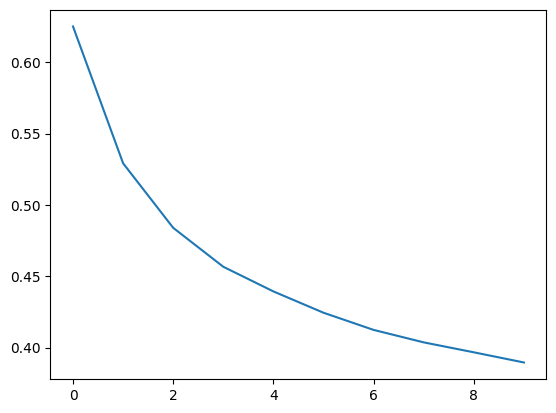

In [14]:
import matplotlib.pyplot as plt

plt.plot(loss_history)

# 8. 학습된 모델과 loader_test 를 이용하여 모델의 성능을 테스트해 봅니다.

In [ ]:
accuracy = 0.0
test_loss = 0.0
correct = 0
pred_history = []

model.to(device)
model.eval()

for X, y in loader_test:
  X, y = X.to(device), y.to(device)

  with torch.no_grad():
    out = model(X)
    loss = loss_fn(out, y)
  
  test_loss += loss.item() * X.size(0)
  _, pred = torch.max(out, 1)
  pred_history.append(pred)
  correct += (pred == y).sum().item()

average_test_loss = test_loss / len(loader_test.dataset)
accuracy = correct / len(loader_test.dataset) * 100
print(f'Loss : {average_test_loss:.4f}, Accuracy : {accuracy:.4f}')

Loss : 0.3836, Accuracy : 86.3983


In [ ]:
mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1).to(device)
std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1).to(device)
images = images * std + mean

In [60]:
dataset_test[0][1]

9

In [58]:
loader_test.dataset[0]

(tensor([[[-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          ...,
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179]],
 
         [[-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          ...,
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357]],
 
         [[-1.8044, -1.8044, -1.8044,  ..., -1.8044, -1.8044, -1.8044],
          [-1.8044, -1.8044,

In [61]:
pred_history[1].shape

torch.Size([1024])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.622571].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.5877128].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.6051416].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.535425].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.622571].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.535425].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.587712

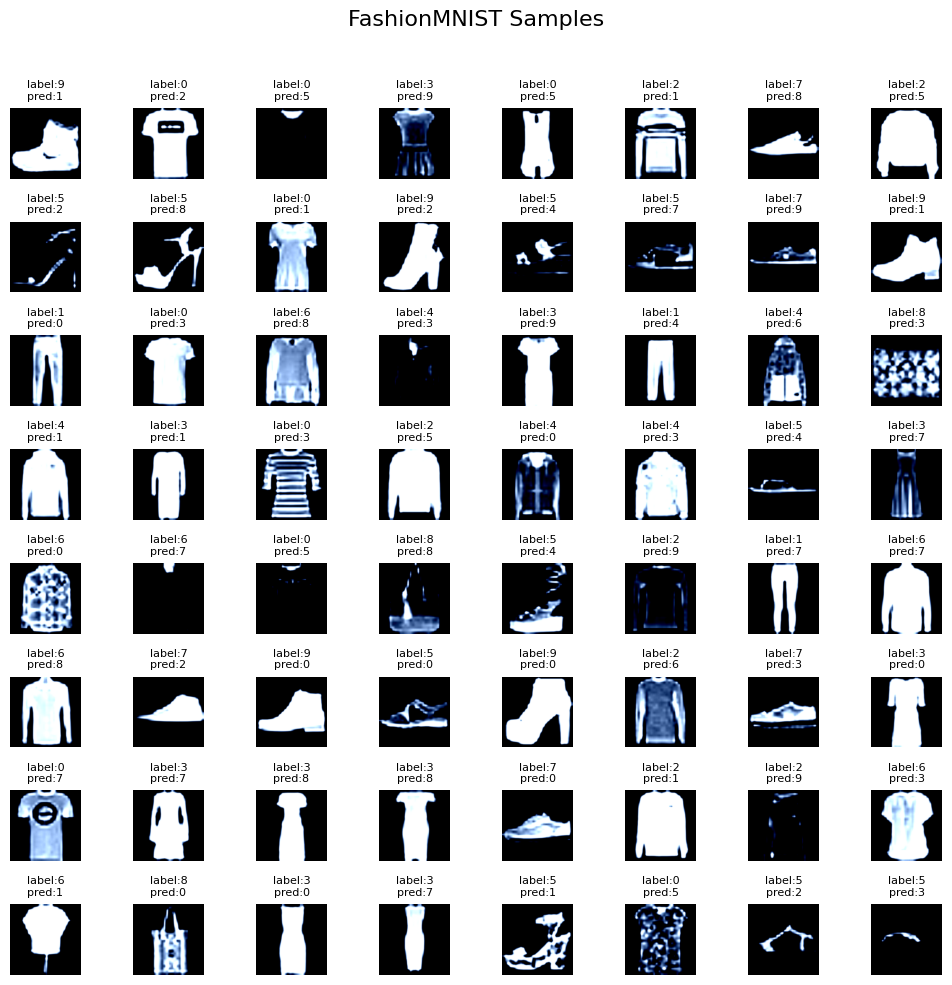

In [59]:
# 시각화 하려는데 loader_test shuffle변수 적용해서 사용한거랑 test_dataset 꺼랑 순서가 다름 어찌하나 
fig, axes = plt.subplots(8, 8, figsize=(10, 10))
fig.suptitle("FashionMNIST Samples", fontsize=16)

for i in range(64):  # 총 64개의 이미지를 출력
    image, label = loader_test.dataset[i]  # 데이터셋에서 i번째 샘플 가져오기
    ax = axes[i // 8, i % 8]  # 서브플롯 위치 계산
    ax.imshow(image.permute(1, 2, 0).squeeze(), cmap="gray")
    ax.set_title(f'label:{label}\npred:{pred_history[0][i]}', fontsize=8)  # 레이블 추가
    ax.axis("off")  # 축 제거

plt.tight_layout(rect=[0, 0, 1, 0.96])  # 레이아웃 조정
plt.show()

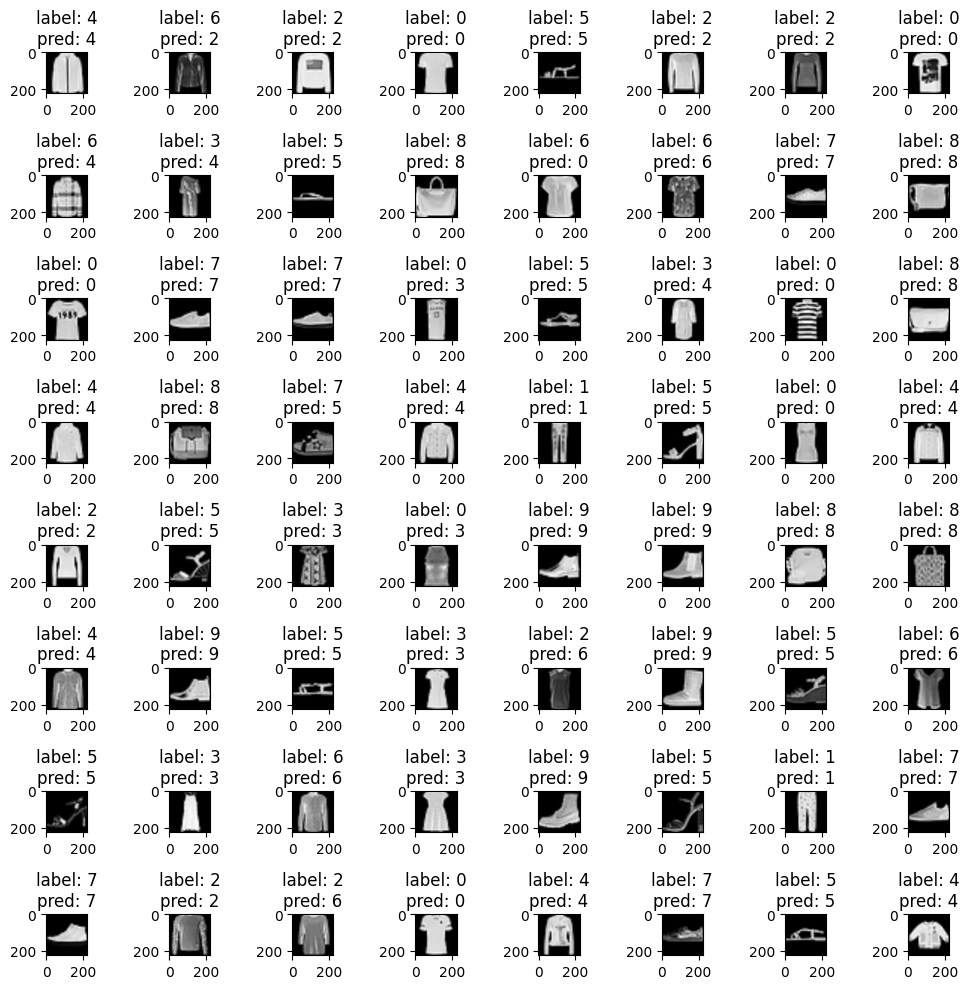

## 9. 교재에서 제공하는 github 자료의 chap06/data/catanddog 데이터를 자신의 개발 환경으로 복사합니다. p296 의 transforms 를 준비합니다. p297 를 참고하여 ImageFolder 클래스를 이용하여 dataset_train, dataset_test 를 준비합니다.

In [31]:
import torchvision.transforms.v2 as v2
from torchvision.datasets import ImageFolder 

train_path = './book/chap06/data/catanddog/train'
test_path = './book/chap06/data/catanddog/test'

train_transforms = v2.Compose([
                      v2.Resize((256, 256)),
                      v2.RandomRotation(5),
                      v2.RandomHorizontalFlip(0.5),
                      v2.ToImage(), 
                      v2.ToDtype(torch.float32, scale=True),
                      v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                    ])
test_transforms = v2.Compose([
                      v2.Resize((256, 256)),
                      v2.ToImage(), 
                      v2.ToDtype(torch.float32, scale=True),
                      v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                    ])

train_dataset = ImageFolder(train_path, transform=train_transforms)
test_dataset = ImageFolder(test_path, transform=test_transforms)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=True)

## 10. 파이토치에서 제공하는 ResNet18 모델을 이용하여 개와 고양이를 구분하는 모델을 transfer learning 방식으로 빌드 후, 훈련 loss, 테스트 데이터를 이용한 모델의 성능을 확인해 봅니다.

In [32]:
model2 = resnet18(weights=weights)

for p in model2.parameters():
  p.requires_grad = False

model2.fc = nn.Linear(512, 2)

for p in model2.fc.parameters():
  p.requires_grad = True

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

In [33]:
def train_model(model, dataloaders, loss_fn, optimizer, device, num_epochs):
  loss_history = []
  
  model.to(device)
  model.train()
  for epoch in range(num_epochs):
    running_loss = 0.0
    for X, y in dataloaders:
      X, y = X.to(device), y.to(device)

      out = model(X)
      loss = loss_fn(out, y)

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      running_loss += loss.item() * X.size(0)

    loss_history.append(running_loss / len(dataloaders.dataset))
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss / len(dataloaders.dataset):.4f}")
  return loss_history

In [34]:
train_loss_history = train_model(model2, train_loader, loss_fn, optimizer, device, num_epochs=10)

Epoch [1/10], Loss: 0.6569
Epoch [2/10], Loss: 0.6649
Epoch [3/10], Loss: 0.6653
Epoch [4/10], Loss: 0.6615
Epoch [5/10], Loss: 0.6535
Epoch [6/10], Loss: 0.6486
Epoch [7/10], Loss: 0.6543
Epoch [8/10], Loss: 0.6542
Epoch [9/10], Loss: 0.6563
Epoch [10/10], Loss: 0.6547


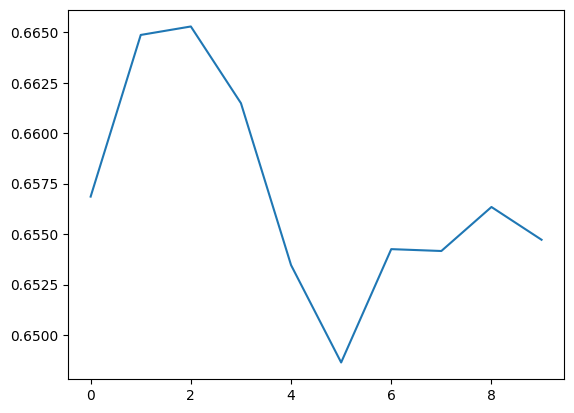

In [35]:
plt.plot(train_loss_history)